# Prepare enviroment

We will use the Scikit-learn library as it will provide us with an interface to apply machine learning techniques.

In [1]:
# we need to use an old version of scikit, otherwise we will face a compatiblity issue with eli5 (needed in order to use permutation importance
# to answer research question #3
# If we do not use this verion, eli5 will try to import a function (if_delegate_has_method) from scikit-learn that no longer exists
# in recent versions of scikit-learn and we will run into an error
!pip install scikit-learn==0.22

  Using cached scikit-learn-0.22.tar.gz (6.9 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [1231 lines of output]
      Partial import of sklearn during the build process.
      /private/var/folders/sk/sy9ttjr53fjfkmt13qcrdcf00000gn/T/pip-install-duq2f9f_/scikit-learn_904caa63eed84c7882d9fef6a8447723/setup.py:123: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/distutils_status_migration.html
      
      
        from numpy.distutils.command.build_ext import build_ext  # noqa
      INFO: C compiler: clang -Wno-unused-

In [2]:
!pip install eli5

In [3]:
# model
from sklearn.svm import SVR # this will make a support vector machine for regression

# permutation
import eli5
from eli5.sklearn import PermutationImportance # the downside of SVM is that it is a 'black-box', this will allow us to access our model and compute feauture importance to answer research question #3 without having to resort to do more work to prepare a i.e., decision tree or bayesian network

# scoring metric
from sklearn.metrics import r2_score, mean_squared_error # to evaluate our SVM

# formatting data
from sklearn.preprocessing import scale # scale and center data
from sklearn.preprocessing import StandardScaler

# model selection
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.model_selection import GridSearchCV # this will do cross validation and allow us to find optimal parameters for our SVM
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold # provides K-Fold Cross Validation, in our case we will have 10 folds (9 subsamples will be used to train the model and the remaining 1 subsample is used to validate the model)

from sklearn.pipeline import make_pipeline

In [4]:
from IPython.display import display, Image

# data wrangling
import pandas as pd
import numpy as np
from scipy.stats import pearsonr


# visualizations
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from seaborn import histplot

In [5]:
import scipy

# Data Pre-processing

## Import data

In [14]:
df_RAW_pre2023 = pd.read_csv('Raw Data/pre-2023.csv')
df_RAW_2023 = pd.read_csv('Raw Data/2023.csv')

## Cleaning

### Removing columns we dont care about

Let's remove the columns with variables that are not present in both datasets.

In [15]:
print(df_RAW_pre2023.columns)
print(df_RAW_2023.columns)

Index(['Country name', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect'],
      dtype='object')
Index(['Country name', 'Ladder score', 'Standard error of ladder score',
       'upperwhisker', 'lowerwhisker', 'Logged GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Ladder score in Dystopia',
       'Explained by: Log GDP per capita', 'Explained by: Social support',
       'Explained by: Healthy life expectancy',
       'Explained by: Freedom to make life choices',
       'Explained by: Generosity', 'Explained by: Perceptions of corruption',
       'Dystopia + residual'],
      dtype='object')


In [16]:
remove_pre2023 = ['Positive affect', 'Negative affect']

df_RAW_pre2023 = df_RAW_pre2023.drop(columns=remove_pre2023)

remove_2023 = ['Standard error of ladder score', 'upperwhisker', 'lowerwhisker',
              'Ladder score in Dystopia', 'Explained by: Log GDP per capita',
              'Explained by: Social support','Explained by: Healthy life expectancy',
              'Explained by: Freedom to make life choices','Explained by: Generosity',
              'Explained by: Perceptions of corruption','Dystopia + residual']

df_RAW_2023 = df_RAW_2023.drop(columns=remove_2023)

Add a `year` column to `df_2023` so that information is not lost if the dataframe is merged with `df_pre2023` in the future,

In [17]:
df_RAW_2023.insert(loc=1, column='year', value=2023)
df_RAW_2023.head()

,Country name,year,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,Finland,2023,7.804,10.792,0.969,71.150,0.961,-0.019,0.182
1,Denmark,2023,7.586,10.962,0.954,71.250,0.934,0.134,0.196
2,Iceland,2023,7.530,10.896,0.983,72.050,0.936,0.211,0.668
3,Israel,2023,7.473,10.639,0.943,72.697,0.809,-0.023,0.708
4,Netherlands,2023,7.403,10.942,0.930,71.550,0.887,0.213,0.379


In [18]:
print(df_RAW_pre2023.columns)
print(df_RAW_2023.columns)

Index(['Country name', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption'],
      dtype='object')
Index(['Country name', 'year', 'Ladder score', 'Logged GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption'],
      dtype='object')


Sanity check: Let's make sure all the dataframes have the same number of columns.

In [19]:
# List of DataFrames
dataframes = [df_RAW_pre2023, df_RAW_2023]

# Count number of columns in each DataFrame
for i, df in enumerate(dataframes):
    num_columns = df.shape[1]
    print("Number of columns in DataFrame", i+1, ":", num_columns)

Number of columns in DataFrame 1 : 9
Number of columns in DataFrame 2 : 9


### Standardize naming scheme for dimensions

Between the two datasets, there is a slight difference in the naming scheme. We the column names to be the same to allow for merging later on.

In [20]:
df_RAW_pre2023.rename(columns={
    'Country name': 'country',
    'year': 'year',
    'Life Ladder': 'happiness',
    'Log GDP per capita': 'GDP',
    'Social support' : 'socialSupport',
    'Healthy life expectancy at birth': 'lifeExpectancy',
    'Freedom to make life choices': 'freedom',
    'Generosity': 'generosity',
    'Perceptions of corruption' : 'corruption',
}, inplace=True)

df_RAW_2023.rename(columns={
    'Country name': 'country',
    'year': 'year',
    'Ladder score': 'happiness',
    'Logged GDP per capita': 'GDP',
    'Social support' : 'socialSupport',
    'Healthy life expectancy': 'lifeExpectancy',
    'Freedom to make life choices': 'freedom',
    'Generosity': 'generosity',
    'Perceptions of corruption' : 'corruption',
}, inplace=True)


In [21]:
print(df_RAW_pre2023.columns)
print(df_RAW_2023.columns)

Index(['country', 'year', 'happiness', 'GDP', 'socialSupport',
       'lifeExpectancy', 'freedom', 'generosity', 'corruption'],
      dtype='object')
Index(['country', 'year', 'happiness', 'GDP', 'socialSupport',
       'lifeExpectancy', 'freedom', 'generosity', 'corruption'],
      dtype='object')


### Merge

In [22]:
df = pd.concat([df_RAW_pre2023, df_RAW_2023], axis=0)
df

,country,year,happiness,GDP,socialSupport,lifeExpectancy,freedom,generosity,corruption
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.168,0.882
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.191,0.850
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.121,0.707
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.164,0.731
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.238,0.776
...,...,...,...,...,...,...,...,...,...
132,Congo (Kinshasa),2023,3.207,7.007,0.652,55.375,0.664,0.086,0.834
133,Zimbabwe,2023,3.204,7.641,0.690,54.050,0.654,-0.046,0.766
134,Sierra Leone,2023,3.138,7.394,0.555,54.900,0.660,0.105,0.858
135,Lebanon,2023,2.392,9.478,0.530,66.149,0.474,-0.141,0.891


### Dealing with NaN or 0 values

Let's make sure we do not have any NA values, since Scikit-learn's support vector machines do not work with datasets with missing values.




In [23]:
df.dtypes # check if there are character-based place holders for missing data

country            object
year                int64
happiness         float64
GDP               float64
socialSupport     float64
lifeExpectancy    float64
freedom           float64
generosity        float64
corruption        float64
dtype: object

In [25]:
print("Number of null or missing values: ",df.isnull().sum().sum())

Number of null or missing values:  310


According to the [statistics appendix](https://s3.amazonaws.com/happiness-report/2018/Appendix1ofChapter2.pdf), 0 is not a meaningful score for any of the variables. Any cells that have a value of zero are actually cells with missing data.

Let's check to see if any observation has a 0 as a value.

In [26]:
zero_indices = np.where(df == 0)
num_zeros = zero_indices[0].shape[0]
print(f'Number of cells with a value of zero: {num_zeros}')

Number of cells with a value of zero: 8


While it seems that some countries have missing data, it is not justifiable to discard the whole observation. In our dataset, usually for country that has missing data, it is only empty for a single variable and still has the 6 other dimensions filled. Therefore, discarding rows with missing information is not a good tradeoff.

Even though some cells have a value of `0` or `NaN`, we can use **interpolation** to estimate a resonable value for these cells and replace these cells.

A linear method of interpolation will draw a straight line between the points surrounding the missing value(s) and use this line to estimate a reasonable value. It's worth noting that we will assumes that the change between the values is constant.

Interpolation works only on cells exclusively with `NaN`. As such, we will replace all 0's with NaN's before proceeding.

In [27]:
df.replace(0, np.nan)
print("Number of null or missing values: ",df.isnull().sum().sum()) # check to see if we successfully replaced 0's

Number of null or missing values:  310


Now that our dataset exclusively has missing data as `NaN`, we can proceed with the interpolation.

In [28]:
df.interpolate(method='linear', inplace=True)
print("Number of null or missing values: ",df.isnull().sum().sum())

Number of null or missing values:  0


Success! We have no more `NaN` values in out dataset.

How many years does our dataframe account for? which countries are missing from each year?

In [29]:
# To identify the countries in df
all_countries = df['country'].unique()
print(f"The dataframe covers the years: {all_countries}")

The dataframe covers the years: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia'
 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo (Brazzaville)' 'Congo (Kinshasa)'
 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia' 'Denmark' 'Djibouti'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Estonia' 'Eswatini'
 'Ethiopia' 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany'
 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Honduras'
 'Hong Kong S.A.R. of China' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iran' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Ivory Coast' 'Jamaica' 'Japan'
 'Jordan' 'Kazakhstan' 'Kenya' 'Kosovo' 'Kuwait' 'Kyrgyzstan' 'Laos'
 'Latvia' 'Lebanon' 'Lesotho' 'Liberia' 'Libya' 'Lithuania' 'Luxem

In [33]:
# To identify the years in df
years = df['year'].unique()
print(f"The dataframe covers the years: {years}")

The dataframe covers the years: [2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2021 2022
 2007 2020 2006 2005 2023]


In [34]:
# To find out which countries are missing for each year:
for year in years:
    countries_in_year = df[df['year'] == year]['country'].unique()
    missing_countries = set(all_countries) - set(countries_in_year)
    print(f"In the year {year}, the following countries are missing: {missing_countries}")

In the year 2008, the following countries are missing: {'South Sudan', 'Guyana', 'Bulgaria', 'Turkmenistan', 'Algeria', 'Guinea', 'Eswatini', 'Greece', 'Kuwait', 'Central African Republic', 'Hungary', 'Serbia', 'Morocco', 'Malawi', 'Belize', 'Suriname', 'Oman', 'Montenegro', 'Gabon', 'Maldives', 'Cuba', 'Switzerland', 'Namibia', 'Gambia', 'Tunisia', 'Slovenia', 'Somaliland region', 'Luxembourg', 'United Arab Emirates', 'Congo (Kinshasa)', 'Albania', 'Cyprus', 'Malta', 'Ethiopia', 'Jamaica', 'Lesotho', 'Comoros', 'Yemen', 'Qatar', 'Sudan', 'Slovakia', 'Romania', 'Libya', 'Poland', 'Croatia', 'North Macedonia', 'Bhutan', 'Czechia', 'Somalia', 'Myanmar', 'Mauritius', 'Angola', 'Bahrain', 'Ivory Coast', 'Bosnia and Herzegovina'}
In the year 2009, the following countries are missing: {'Burkina Faso', 'South Sudan', 'Guyana', 'Portugal', 'Bulgaria', 'Algeria', 'Guinea', 'Iran', 'Central African Republic', 'Morocco', 'Belize', 'Australia', 'Suriname', 'Oman', 'Taiwan Province of China', 'Gabo

# **Q1:** Can we predict this year's (2023) happiness?

Happiness is considered an indicator of societal health. If a government can predict its citizens' happiness accurately, it can use that information to evaluate the success of its current policies and make adjustments where necessary.

We already have the 2023 data. What we can do is train a model on the pre-2023 data to see if the predicted 2023 scores actually match the actual ones. If the model we build has a high accuracy, we can forecast 2024 scores!

Our ultimate goal is to predict the 2023 data, and were interested in seeing how well our model performs specifically on this year, we wil exclude the 2023 data from our training and testing sets entirely. We will then train our model on the pre-2023 data, and once the model is trained, use it to make predictions on the 2023 data.

## Pre-processing for this specific model

In [35]:
df_pre2023 = df[df['year'] < 2023] # we will train and test our model on this dataframe
df_2023 = df[df['year'] == 2023] # well compare predicted data with this dataframe

**Why did we choose SVM?**

### Dealing with countries present in pre-2023 data, but not 2023 (or vice versa)


Some countries present in your training data are not present in the 2023 data, which cause an issue in our model later on as it expects to see the same features (in this case, countries) in both the training and testing data.

In [36]:
# Get a list of all unique countries in each dataframe
countries_pre2023 = set(df_pre2023['country'].unique())
countries_2023 = set(df_2023['country'].unique())

# Find countries present in pre-2023 data but not 2023
missing_in_2023 = countries_pre2023 - countries_2023
print("Countries present in pre-2023 data but not 2023:")
print(missing_in_2023)

# Find countries present in 2023 data but not pre-2023
missing_in_pre2023 = countries_2023 - countries_pre2023
print("\nCountries present in 2023 data but not pre-2023:")
print(missing_in_pre2023)

Countries present in pre-2023 data but not 2023:
{'South Sudan', 'Guyana', 'Rwanda', 'Turkmenistan', 'Kuwait', 'Central African Republic', 'Belize', 'Suriname', 'Oman', 'Maldives', 'Cuba', 'Somaliland region', 'Burundi', 'Lesotho', 'Syria', 'Yemen', 'Qatar', 'Sudan', 'Libya', 'Trinidad and Tobago', 'Bhutan', 'Somalia', 'Belarus', 'Haiti', 'Djibouti', 'Angola', 'Eswatini', 'Azerbaijan'}

Countries present in 2023 data but not pre-2023:
set()


It turns out the countries the 2023 dataframe is missing are:

 'Azerbaijan', 'Turkmenistan', 'Qatar', 'Angola', 'Belize', 'Oman', 'Belarus', 'Bhutan', 'Libya', 'Kuwait', 'Trinidad and Tobago', 'Djibouti', 'Maldives', 'Cuba', 'Haiti', 'Rwanda', 'South Sudan', 'Syria', 'Central African Republic', 'Eswatini', 'Somaliland region', 'Guyana', 'Yemen', 'Suriname', 'Burundi', 'Lesotho', 'Sudan', 'Somalia'

Hence, we need to remove these countries from the pre-2023 dataframe.

In [37]:
df_pre2023

,country,year,happiness,GDP,socialSupport,lifeExpectancy,freedom,generosity,corruption
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.168,0.882
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.191,0.850
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.121,0.707
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.164,0.731
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.238,0.776
...,...,...,...,...,...,...,...,...,...
2194,Zimbabwe,2018,3.616,7.783,0.775,52.625,0.763,-0.051,0.844
2195,Zimbabwe,2019,2.694,7.698,0.759,53.100,0.632,-0.047,0.831
2196,Zimbabwe,2020,3.160,7.596,0.717,53.575,0.643,0.006,0.789
2197,Zimbabwe,2021,3.155,7.657,0.685,54.050,0.668,-0.076,0.757


In [38]:
remove_countries = ['Azerbaijan', 'Turkmenistan', 'Qatar', 'Angola', 'Belize',
                    'Oman', 'Belarus', 'Bhutan', 'Libya', 'Kuwait', 'Trinidad and Tobago',
                    'Djibouti', 'Maldives', 'Cuba', 'Haiti', 'Rwanda', 'South Sudan',
                    'Syria', 'Central African Republic', 'Eswatini', 'Somaliland region',
                    'Guyana', 'Yemen', 'Suriname', 'Burundi', 'Lesotho', 'Sudan', 'Somalia']

# Filter the dataframe so only countries we want are left
df_pre2023 = df_pre2023[~df_pre2023 ['country'].isin(remove_countries)]

### Model formatting

To avoid data leakage, we need to split variables into indepdent and dependent variables then perform one-hot encoding. We also need to split our data into training and test sets before scale our data.

### Split the data into dependent and independent variables




Let's format the data so we can be ready to create a support vector machine.

In this case, the variable we want to predict is data from the 'happiness' coloumn. We will store this in **y**.

The remaining other coloumns will correspond to our classification variables. This data will be store in **X**.

So the independent variables are: `'country', 'year', 'GDP', 'socialSupport',
       'lifeExpectancy', 'freedom', 'generosity', 'corruption'`

In [39]:
# we will make a copy of our df so as to not modify the original.

X = df_pre2023.drop('happiness', axis=1).copy()
X_2023 = df_2023.drop('happiness', axis=1).copy()

In [40]:
y = df_pre2023['happiness'].copy()
y_2023 = df_2023['happiness'].copy()

### One-hot encoding **EDIT COMMENTS**

In our datasets, we have one categorical column; country. We can't just plug it into our SVM as is, because SVM requires numerical input.

Luckily we can use a trick to bypass this issue by using one-Hot encoding.

One-hot encoding will create a binary column for each category in the feature. The only downside is that the dimensionality of out data will increase since we have 195 countries in the world. Even though we could maintain dimensionality by using ordinal encoding, we will not use it as it would assign a value to each country, implying a ranking--which is not true in our case. It would, for an example, cluster country 193, 194, 195 together because it would assume they are similiar.

This type of data pre-procesing needs to happen after data splitting to prevent "data leakage".

In [41]:
X_encoded = pd.get_dummies(X, columns=['country'])
X_encoded_2023 = pd.get_dummies(X_2023, columns=['country'])
X_encoded.head()

,year,GDP,socialSupport,lifeExpectancy,freedom,generosity,corruption,country_Afghanistan,country_Albania,country_Algeria,...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Venezuela,country_Vietnam,country_Zambia,country_Zimbabwe
0,2008,7.350,0.451,50.5,0.718,0.168,0.882,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2009,7.509,0.552,50.8,0.679,0.191,0.850,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2010,7.614,0.539,51.1,0.600,0.121,0.707,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011,7.581,0.521,51.4,0.496,0.164,0.731,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2012,7.661,0.521,51.7,0.531,0.238,0.776,1,0,0,...,0,0,0,0,0,0,0,0,0,0


You can see that the outcome of hot-encoding is that, for example, the row corresponding to the UAE has a 0 for all country columns (i.e., country_Afghanistan, country_Albania, country_Algeria) except for the column country_United_Arab_Emirates--this is how we maintain the country information for each column in a numerical format.

Since our model performed really well at predicting this year, lets forcast the happiness of contries in the upcoming year.

**check which countries have missing years** Even though the survey claims to have included data about 156 countries, there are only a small number of countries for which data has been recorded in the initial years.



### Splitting into training and test set & scaling **EDIT COMMENTS**

NOTE: Another reason why we already split the dataset into a training and test dataset is to avoid data leakage while scaling. Data leakage in this case means that the information about the training set corrupts the testing one.

K-Fold Cross Validation is a popular resampling technique used to evaluate models on a limited data sample. The primary goal of cross-validation is to prevent overfitting, but it also gives insight into how the model will generalize to an independent dataset.

In K-Fold Cross Validation, the original sample is randomly partitioned into k equal sized subsamples (or "folds"). Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k-1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation.

When k equals 10 (i.e., 10-fold cross validation), this means that the original sample is randomly divided into 10 subsamples. For each of 10 iterations, 9 subsamples are used to train the model and the remaining 1 subsample is used to validate the model (i.e., assess its performance). The final model performance is then typically the average performance across the 10 iterations.

This method is particularly useful when you have a small dataset because it maximizes both the test and training data. However, it also has a higher computational cost as the model needs to be trained k times.

Another variation of K-Fold Cross Validation is Stratified K-Fold Cross Validation where each set contains approximately the same percentage of samples of each target class as the complete set, or in case of prediction problems, the mean response value is approximately equal in all the folds. This is generally a better option as it takes imbalance in the data distribution into account.

The `random_state` parameter is a way to set the seed for the pseudo-random number generator used in the algorithm, particularly for methods that involve random processes such as random subsampling, randomly initializing parameters, etc.

The actual number you use as a seed doesn't matter so much. What's important is that the same seed will result in the same random sequence, providing reproducibility for your analysis.

So if you set `random_state` to a high number, it won't affect the quality of your model or its ability to generalize. It will just start the random number generator at a different point in its sequence compared to if you used a lower seed. But as long as you use the same seed each time (whatever that number may be), you'll get the same results each time you run your code.

If you don't set `random_state`, each time you run your code you may get different results, because the seed for the random number generator will be set randomly (often using the current time), causing your code to start at a different point in the random sequence each time it's run.

The most important consideration with `random_state` is to set it the same way each time if you want reproducible results, not whether the seed is a small or large number.

Creating a "fold" in the context of k-fold cross-validation refers to splitting the data into several subsets of roughly equal size.

For instance, when you perform 10-fold cross-validation, you divide your dataset into 10 "folds" or subsets. If you have 1000 samples in your dataset, each fold will have approximately 100 samples.

For each round of cross-validation, one of these folds is used as the testing set and the remaining folds are combined to form the training set. The model is trained on the training set and evaluated on the testing set.

This process is repeated 10 times (or however many folds you have), each time with a different fold being used as the test set. This way, each sample in your dataset is included in the test set exactly once.

The advantage of k-fold cross-validation is that it allows you to use all of your data for both training and testing, which can lead to more robust estimates of the model's performance.

Here's an example with 5-fold cross-validation:

- Round 1: Train on folds 2, 3, 4, 5; test on fold 1
- Round 2: Train on folds 1, 3, 4, 5; test on fold 2
- Round 3: Train on folds 1, 2, 4, 5; test on fold 3
- Round 4: Train on folds 1, 2, 3, 5; test on fold 4
- Round 5: Train on folds 1, 2, 3, 4; test on fold 5

Each "fold" is used once as the test set, and the model's performance is averaged across the 5 rounds to get the final model performance.

In [42]:
# lets create folds and tell the KFold function whether or not to shuffle the data beforehand.
kf = KFold(n_splits=10, shuffle=True, random_state=1)

The Radial Basis Function (RBF) kernel we are using for our Support Vector Machine assumes that the data is centered and scaled. The RBF kernel measures the similarity between samples based on the Euclidean distance, and if the data is not scaled, features with larger scales can dominate the distance computation and have a disproportionate impact on the model.

The scaling process involves subtracting the mean of each feature and dividing it by the standard deviation. In other words, each column should have a mean value of 0 and a standard deviation of 1. We need to do this in both the training and testing datasets.

Scaling data is a form of preprocessing, and generally, preprocessing steps should be performed within each fold of the cross-validation process. If you perform scaling before the cross-validation, the scaling parameters (mean, standard deviation for standard scaling, for instance) would be computed using all of the data, including the test data that's supposed to be "unseen". This could lead to information leakage from the test set into the training set, which may lead to overly optimistic performance metrics.

The correct way is to compute the scaling parameters (i.e., fit the scaler) on the training set of each fold, then apply those parameters to scale the data in both the training and test sets.

Here's a general procedure using `StandardScaler` and `KFold` in scikit-learn as an example:


In this way, each fold gets its own "view" of the world that is not contaminated by the test data.

This process becomes easier when you use `Pipeline` in scikit-learn, which allows you to define a pipeline of transformations that end with a classifier or regressor. When using `cross_val_score` or other similar functions with a pipeline, the fitting of the preprocessing steps will automatically happen on the training data of each fold.

In [43]:
# Initialize the scaler
scaler = StandardScaler()

# Prepare empty lists to hold the training and testing data for each fold
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

for train_index, test_index in kf.split(X_encoded):
    # Split the data
    X_train, X_test = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the scaler on the training set and transform both sets
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Append to the lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

## Initializing support vector machine **EDIT COMMENTS**

Our problem is a regression one, not a classification one since we are working with continuous target values (e.g., predicting a numerical value, in our case, happiness).

In [44]:
# Initialize the SVR model
model = SVR()

# Create an empty list to store scores for each fold
r2_scores = []
rmse_scores = []
accuracy_scores = []

# Define the threshold
threshold = 0.1  # 10% acceptable limit of error (the percentage of the true value that you'll allow as error)

for i in range(kf.get_n_splits()):
    # Get the data for this fold
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate and store the performance metrics
    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # computing accuracy
    relative_error = np.abs((y_test - y_pred) / y_test) # Compute the relative error
    correct_predictions = np.sum(relative_error <= threshold) # Count the number of predictions that fall within the threshold
    accuracy_scores.append(correct_predictions / len(y_test)) # Compute and store the accuracy for this fold

# Print average performance metrics
print("Average R^2 Score:", np.mean(r2_scores))
print("Average RMSE:", np.mean(rmse_scores))
print('Average Accuracy: ', np.mean(accuracy_scores)) # Print average accuracy

Average R^2 Score: 0.8882538776050592
Average RMSE: 0.3718669854963271
Average Accuracy:  0.8505714968914395


So far we defined and fit the SVM regression model within each fold on the pre-2023 data. Currently, out of the box, our SVM model performed pretty well:

 R^2 = `0.889`, RMSE = `0.372`, Accuracy = `85.1%`

Accuracy: If the difference between the predicted and actual values falls within this threshold, then the prediction is deemed correct.

Computing averages for the performance metrics across the multiple folds of a cross-validation process gives us an overall understanding of the model's performance, while reducing the variance and bias that might come from a single split of the data.

Here are some more detailed reasons:

1. **Generalization**: The average performance metrics provide a more general evaluation of the model's ability to predict new, unseen data. Since in k-fold cross-validation each fold serves as a test set once, we are essentially testing the model's performance on the entire dataset, which should give us a good estimate of how well the model will perform on new data.

2. **Stability**: Averaging metrics over multiple folds helps to ensure that the evaluation is stable and reliable, not overly dependent on a particular random split of the data. The variance of the estimate decreases as the number of folds increases.

3. **Bias/Variance Trade-off**: Cross-validation allows us to balance bias and variance. A model that performs well on average across many different splits of the data is less likely to be suffering from high bias (underfitting) or high variance (overfitting), as both of these issues would likely cause poor performance on at least some of the folds.

So, the averaging process in k-fold cross-validation serves to give a more reliable and less biased estimate of the model's true performance than would be obtained from a single train/test split.

## Tune/optimize model parameters

Though our model perfromed quite well, let's find the optimal values for our model paramerts to see if we can improve performance.


So let's use cross validation with the hopes of improving the accuracy on the **testing dataset** from the pre-2023 data.

Since we have more than one parameter to optimize, we will use GridSearchCV() to test all possible combinations.

**Epsilon**: SVR uses the epsilon parameter to specify the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.
**C**: Regularization parameter

The below block of code takes ~10min to run. Hence it is commented out for now, but below are the ideal parameters found after running it last time.

We see that the ideal parameter values are C = `100`, epsilon = `0.1`, gamma= `'auto'`, and kernel = `rbf`.


In [45]:
# # Define the grid of parameters to search
# param_grid = [
#     {
#         'C': [0.5, 1, 10, 100], # Note: Values of C > 0
#         'gamma':['scale', 'auto', 1, 0.1, 0.001, 0.0001],
#         'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#         'kernel': ['rbf'] # 'linear' was also previously added, but since gridsearch computed rbf as optimal, we will remove 'linear' to reduce future run time.
#     },
# ]
# # We are including C=1 and gamma=0.1 since they are the default values

# # Initialize the grid search
# grid_search = GridSearchCV(model,
#                            param_grid,
#                            cv=kf, # cross-validation splitting strategy. the function will use the k-fold cross-validation strategy defined by the kf object.
#                            scoring='neg_mean_squared_error',
#                            n_jobs=-1) # n_jobs, the higher number, more messages

# # Conduct the grid search
# grid_search.fit(X_encoded, y)

# print(grid_search.best_params_) # print the optimal parameters

## Building final support vector machine

In [46]:
# Initialize the SVR model
model = SVR(kernel='rbf', C = 100, epsilon = 0.1, gamma = 'auto')

# Create an empty list to store scores for each fold
r2_scores = []
rmse_scores = []
accuracy_scores = []

# Define the threshold
threshold = 0.1  # 10% acceptable limit of error (the percentage of the true value that you'll allow as error)

for i in range(kf.get_n_splits()):
    # Get the data for this fold
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate and store the performance metrics
    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # computing accuracy
    relative_error = np.abs((y_test - y_pred) / y_test) # Compute the relative error
    correct_predictions = np.sum(relative_error <= threshold) # Count the number of predictions that fall within the threshold
    accuracy_scores.append(correct_predictions / len(y_test)) # Compute and store the accuracy for this fold

# Print average performance metrics
print("Average R^2 Score:", np.mean(r2_scores))
print("Average RMSE:", np.mean(rmse_scores))
print('Average Accuracy: ', np.mean(accuracy_scores)) # Print average accuracy

Average R^2 Score: 0.8915699608179251
Average RMSE: 0.363640060888052
Average Accuracy:  0.8505738880918221


Without tuning:  R^2 = `0.889`, RMSE = `0.372`, Accuracy = `85.1%`

Aftering tuning: R^2 = `0.892`, RMSE = `0.364`, Accuracy =  `85.1%`

The SVM preformed really well straight out of the box, with only slight improvements being added to the R^2 and RSME after optimization, but no changce in accuracy.


## Evaluation: How close is our model predictions to actual 2023 data?

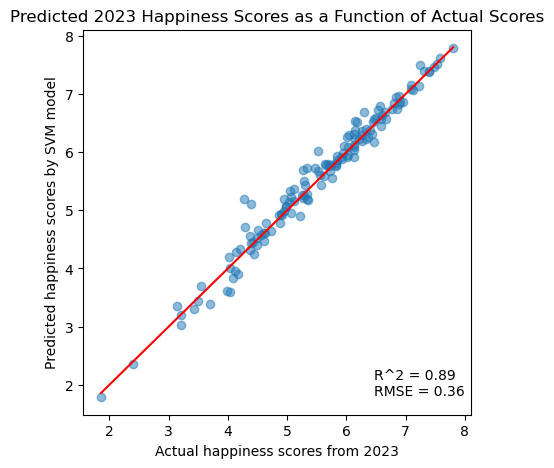

In [47]:
# Predict the 2023 data using the trained model
y_pred_2023 = model.predict(scaler.transform(X_encoded_2023))

# Create a scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(y_2023, y_pred_2023, alpha=0.5)
plt.xlabel('Actual happiness scores from 2023')
plt.ylabel('Predicted happiness scores by SVM model')
plt.title('Predicted 2023 Happiness Scores as a Function of Actual Scores')

# Line of equality
plt.plot([min(y_2023), max(y_2023)], [min(y_2023), max(y_2023)], color='red')

# annotate
avg_r2 = np.mean(r2_scores)
avg_rmse = np.mean(rmse_scores)
plt.annotate(f'R^2 = {avg_r2:.2f}\nRMSE = {avg_rmse:.2f}', xy=(0.75, 0.05), xycoords='axes fraction')

plt.show()

1. The points fall along the line of equality. The closer the points are to this line, the more accurate the model's predictions are.
2. There is a tight cluster of points around the line of equality, implying a more precise model.
3. There is no systematic pattern to the points deviating from the line of equality (for example, if points for lower actual values are consistently overpredicted), this could indicate that the model does not have a bias / captures the relationship between the predictors and the outcome variable.

## Further performance evaluations

### Does our prediction model have a lot of error?


 visualizes the errors in out predictions. Ideally, residuals should be randomly and evenly distributed around the x-axis, and shouldn't form any discernible pattern.

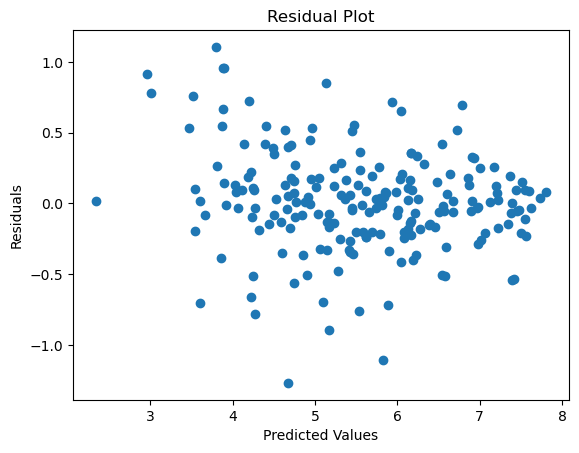

In [48]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### How much are our predictions off by?
**What does the distribution mean in plain words?**

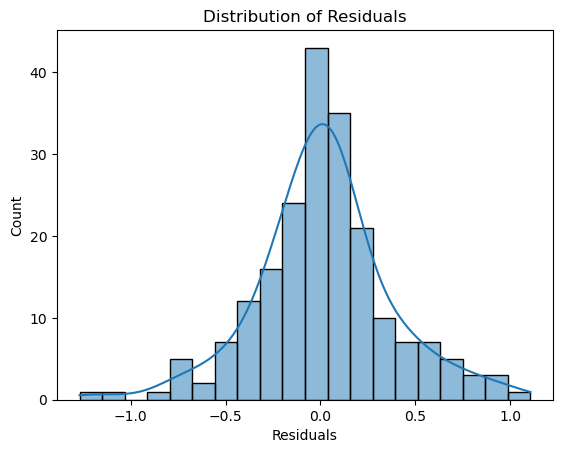

In [49]:
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

* Hard to predict the future! Just because our model performed well on 2023 data, there is no guarantee it will perform as well on the next year's data. The underlying relationships between variables might change over time. A model can make predictions for 2024, but we won't be able to validate these predictions against actual values as we did for the previous years, because the real 2024 data is not available yet.

* If there are large year-to-year fluctuations in happiness scores or the predictors, the model might not produce accurate predictions for 2024.
* the predictions are essentially a replication of 2023's data with some minor alterations due to the model. They don't account for potential new information or significant changes that may occur in 2024.

# **Q2:** Can we predict 2024 happiness?

Since our model performed so well, it is reasonable to try an use to forecast the upcoming year.

## Format data

To avoid data leakage, we need to split our data into training and test sets before scale our data.

### Split the data into dependent and independent variables

Where as in the 2023 model, the training and test dataset did not include 2023 data. In this model, 2023 data is included too.

In [50]:
# we will make a copy of our df so as to not modify the original.
X = df.drop('happiness', axis=1).copy()
y = df['happiness'].copy()

### One-hot encoding

In [51]:
X_encoded = pd.get_dummies(X, columns=['country'])
X_encoded.head()

,year,GDP,socialSupport,lifeExpectancy,freedom,generosity,corruption,country_Afghanistan,country_Albania,country_Algeria,...,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Venezuela,country_Vietnam,country_Yemen,country_Zambia,country_Zimbabwe
0,2008,7.350,0.451,50.5,0.718,0.168,0.882,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2009,7.509,0.552,50.8,0.679,0.191,0.850,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2010,7.614,0.539,51.1,0.600,0.121,0.707,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011,7.581,0.521,51.4,0.496,0.164,0.731,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2012,7.661,0.521,51.7,0.531,0.238,0.776,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Splitting into training and test set & scaling

In [52]:
# lets create folds and tell the KFold function whether or not to shuffle the data beforehand.
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Initialize the scaler
scaler = StandardScaler()

# Prepare empty lists to hold the training and testing data for each fold
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

for train_index, test_index in kf.split(X_encoded):
    # Split the data
    X_train, X_test = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the scaler on the training set and transform both sets
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Append to the lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

## Building support vector machine

In [53]:
# Initialize the SVR model
model = SVR(kernel='rbf', C = 100, epsilon = 0.1, gamma = 'auto')

# Create an empty list to store scores for each fold
r2_scores = []
rmse_scores = []
accuracy_scores = []

# Define the threshold
threshold = 0.1  # 10% acceptable limit of error (the percentage of the true value that you'll allow as error)

for i in range(kf.get_n_splits()):
    # Get the data for this fold
    X_train = X_train_list[i]
    X_test = X_test_list[i]
    y_train = y_train_list[i]
    y_test = y_test_list[i]

    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate and store the performance metrics
    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # computing accuracy
    relative_error = np.abs((y_test - y_pred) / y_test) # Compute the relative error
    correct_predictions = np.sum(relative_error <= threshold) # Count the number of predictions that fall within the threshold
    accuracy_scores.append(correct_predictions / len(y_test)) # Compute and store the accuracy for this fold

# Print average performance metrics
print("Average R^2 Score:", np.mean(r2_scores))
print("Average RMSE:", np.mean(rmse_scores))
print('Average Accuracy: ', np.mean(accuracy_scores)) # Print average accuracy

Average R^2 Score: 0.8976094975041727
Average RMSE: 0.35793757576772134
Average Accuracy:  0.8625820769597594


these metrics are computed within a cross-validation loop for the support vector regression model. This is what is happening:

1. In each fold of the cross-validation, the dataset is split into a training set (X_train, y_train) and a testing set (X_test, y_test). The specific split depends on the fold - different folds will have different splits of the data into training and testing sets.
2. The model is then fitted on the training data and used to predict the outputs (y_pred) for the test data (X_test).
3. These predictions are then compared to the true outputs for the test data (y_test) to compute the R^2 score, the root mean square error (RMSE), and the accuracy.
These are the metrics computed based on the predicted and actual values within each cross-validation fold (not on the actual 2023 and predicted 2024 values).

Why are we doing this? By computing the metrics on the predicted and actual values within each cross-validation fold during the model training and validation phase, we can estimate how well the model is expected to perform on unseen 2024 data based on our available data.

 R^2 = `0.898`, RMSE = `0.358`, Accuracy =  `86.3%`

The SVM preformed really well.


## Preparing X variables for 2024 forecasting

After training our Support Vector Machine model on the data from 2005-2023, we will use this trained model to forecast the 'happiness' score (y) for the year 2024.

However, in order to make this prediction, we will first need the predictor variables (X) for the year 2024.

Since the predictor variables for 2024 are time-independent, we can simply extract the most recent available data for those variables.

In [54]:
X_2024 = df[df['year'] == 2023] # Get the most recent data for each country
X_2024 = X_2024.drop('happiness', axis=1) # Remove the 'happiness' column, as it's the target variable

# we need to make sure X_2024 is processed in the same way as our training data (2005-2023)

# One-hot encode the 'country' column to match the training data
X_2024_encoded = pd.get_dummies(X_2024, columns=['country'])

# Ensure that the 2024 data has the same columns as the training data
missing_cols = set(X_encoded.columns) - set(X_2024_encoded.columns)
for c in missing_cols:
    X_2024_encoded[c] = 0

# Make sure the columns are in the same order as in the training data
X_2024_encoded = X_2024_encoded[X_encoded.columns]

# Scale the 2024 data using the same scaler object used on the training data
X_2024_scaled = scaler.transform(X_2024_encoded)

Let's add confidence intervals for our prediction. 

Since SVMs are not probailistic models, they do not inherently provide a way for us to calculate confidence intervals (unlike e.g., linear regression). However, we can use a rough approach to generate confidence intervals for our model through bootstrapping. Using bootstrapping will allow us to draw samples from the dataset we used to predict 2024 data. It then replaces the taken samples to fit the model again and again, giving us a distribution of the estimates. With this distribution, we can take it's percentiles to create confidence intervals.

It should be noted that bootstrapping is a very computationally expensive, so **expect a long run-time** for the code block below. As per the last run time, total time elapsed was 1hr 7min.

In SVMs, these intervals do not necessarily capture the model's uncertainty about its predictions (unlike models that assume a normal distribution e.g., bayesian model), but rather the variability in the predictions that arises when re-fitting the model to different samples of the data.

A 95% confidence interval, in our case, means that if we were to repeat the sampling process many times, we would expect the true value to fall within this interval 95% of the time. However, this interpretation doesn't imply that there's a 95% chance the true value is within the interval; rather, it's a statement about the method's reliability if the process was repeated many times.

In [120]:
# import time # we will add a timer to see how long it takes to bootstrap our dataset.
# start_time = time.time()

# from sklearn.utils import resample

# # Initialize the SVR model
# model = SVR(kernel='rbf', C = 100, epsilon = 0.1, gamma = 'auto')

# n_iterations = 1000  # Number of bootstrap samples to create
# bootstrap_prediction_list = []

# # Fitting and evaluating the model for each fold
# for i in range(kf.get_n_splits()):
#     # Get the data for this fold
#     X_train = X_train_list[i]
#     X_test = X_test_list[i]
#     y_train = y_train_list[i]
#     y_test = y_test_list[i]

#     # Fitting the model and make predictions
#     model.fit(X_train, y_train)

#     for _ in range(n_iterations):
#         # Preparing a bootstrap sample
#         X_train_resample, y_train_resample = resample(X_train, y_train)
        
#         # Fitting model on the bootstrap sample
#         model_resample = SVR(kernel='rbf', C = 100, epsilon = 0.1, gamma = 'auto').fit(X_train_resample, y_train_resample)
        
#         # Predicting on the 2024 data
#         y_pred_2024_resample = model_resample.predict(X_2024_scaled)
        
#         bootstrap_prediction_list.append(y_pred_2024_resample)

# bootstrap_predictions = np.array(bootstrap_prediction_list)

# # Calculating lower and upper percentiles
# lower = np.percentile(bootstrap_predictions, 2.5, axis=0)
# upper = np.percentile(bootstrap_predictions, 97.5, axis=0)




# end_time = time.time()
# print("Execution time: ", end_time - start_time, "seconds")

Execution time:  4049.783894777298 seconds


Create a plot with the confidence intervals.

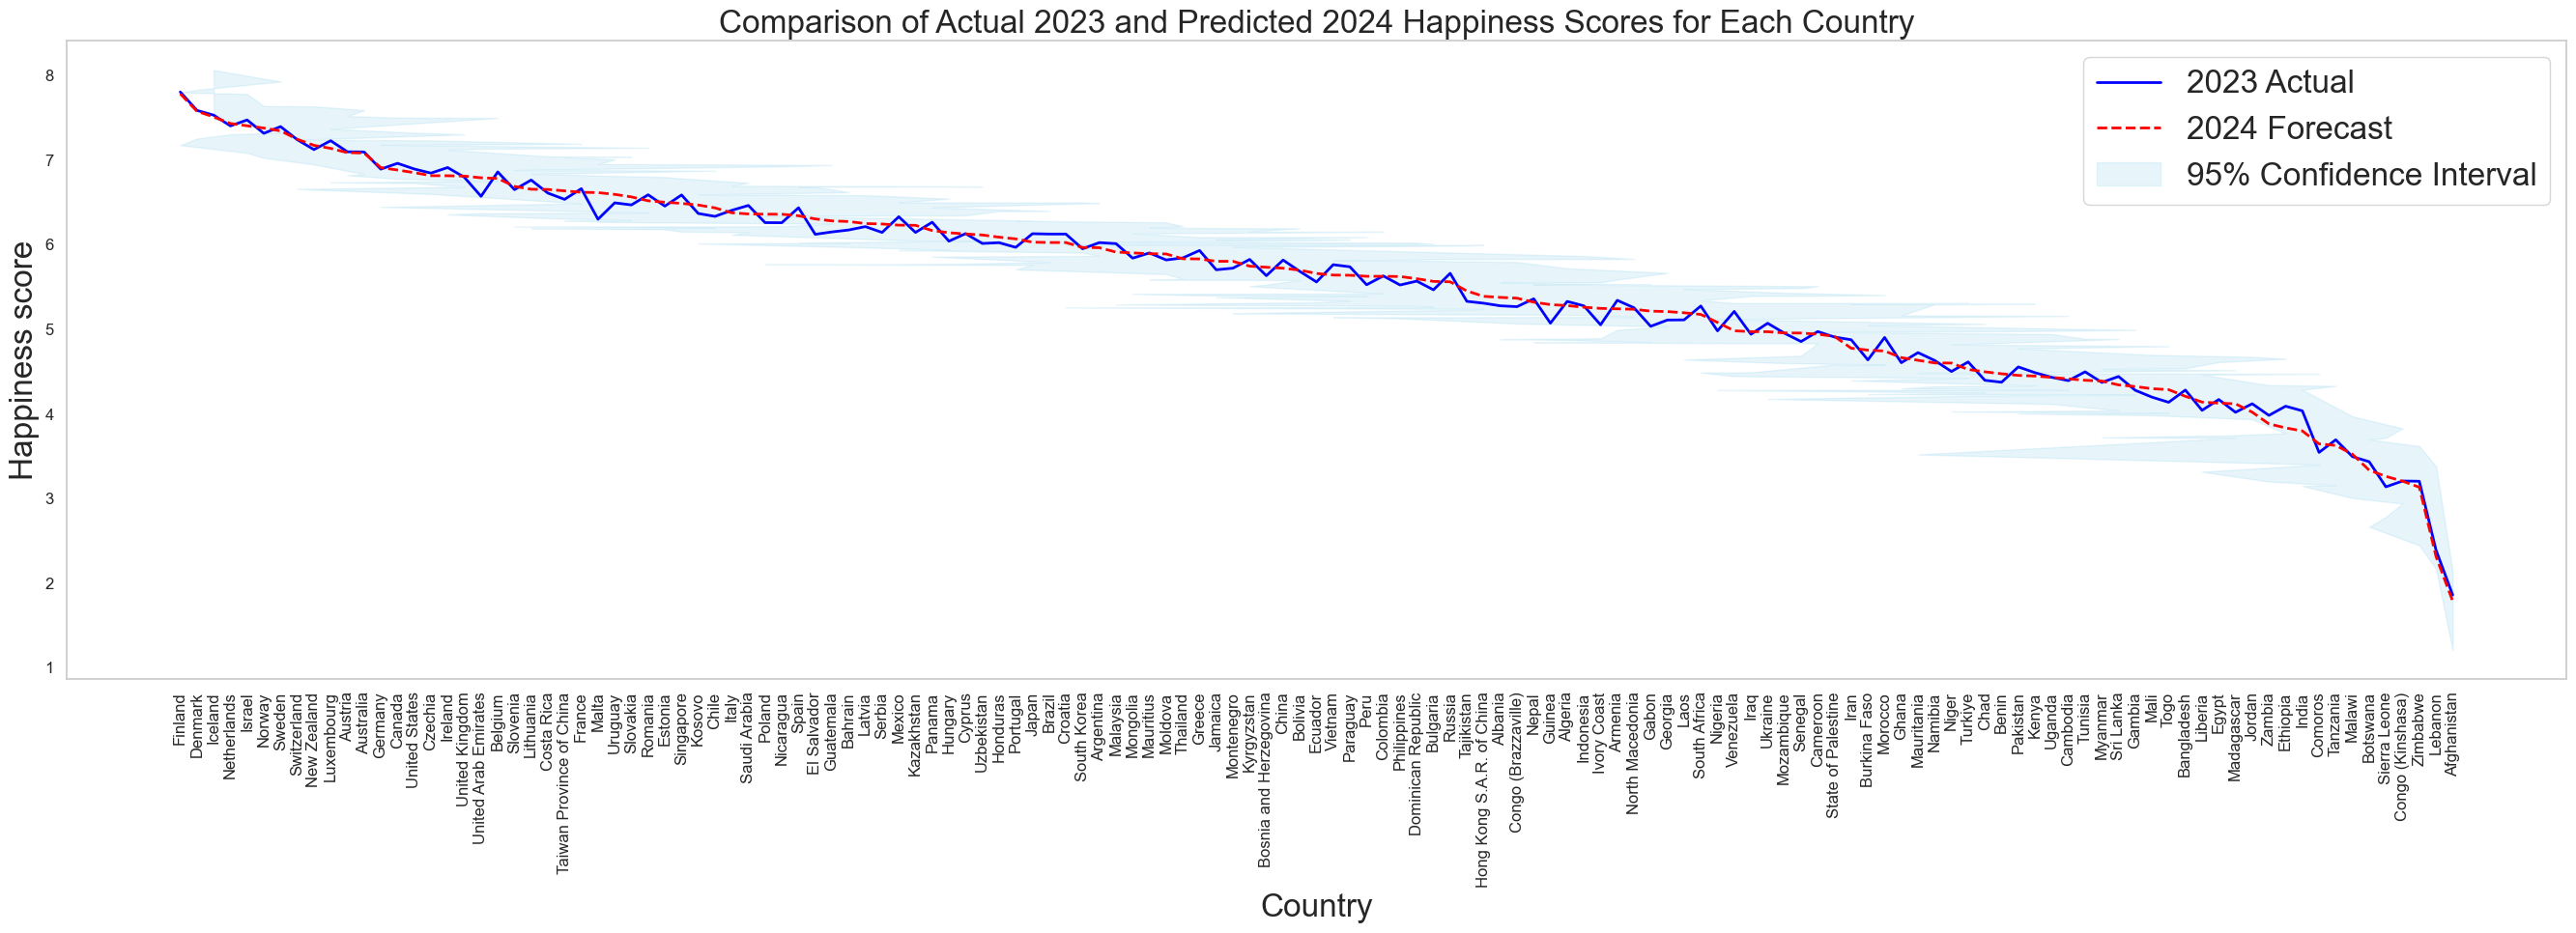

In [132]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

plt.figure(figsize=(27, 10))

# actual 2023 happiness scores
plt.plot(df_2023_sorted['country'], df_2023_sorted['happiness'], label='2023 Actual', color='blue', linewidth=2)

# forecast
plt.plot(df_pred_2024_sorted['country'], df_pred_2024_sorted['happiness'], label='2024 Forecast', color='red', linestyle='dashed', linewidth=2)

# Add the confidence intervals to the plot
plt.fill_between(df_lower_sorted['country'], df_lower_sorted['happiness'], df_upper_sorted['happiness'], color='skyblue', alpha=0.2)

plt.xlabel('Country', fontsize=24)
plt.ylabel('Happiness score', fontsize=24)
plt.title('Comparison of Actual 2023 and Predicted 2024 Happiness Scores for Each Country', fontsize=24)
plt.xticks(fontsize=12, rotation=90) # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.legend(['2023 Actual', '2024 Forecast', '95% Confidence Interval'], fontsize=24)

# Remove grid lines and set background to white
plt.grid(False)
plt.gca().set_facecolor('white')

plt.tight_layout() # ensures that the full labels of the x-axis are displayed
plt.show()

Visually, it seems like all countries have a forecast that falls in the confidence interval. However, it is hard to tell for Finland, denmark and iceland if that is actually the case. Let's check:

In [136]:
# Merge all predictions and their confidence intervals into a single DataFrame
df_all = df_pred_2024_sorted.merge(df_lower_sorted, on='country', suffixes=('_pred', '_lower'))
df_all = df_all.merge(df_upper_sorted, on='country')
df_all.rename(columns={'happiness': 'happiness_upper'}, inplace=True)

outliers = [] # Initialize a list to hold the names of countries that do not fall within the confidence interval

# Check each country
for i in df_all.index:
    if not df_all.loc[i, 'happiness_lower'] <= df_all.loc[i, 'happiness_pred'] <= df_all.loc[i, 'happiness_upper']:
        outliers.append(df_all.loc[i, 'country'])

# Print 
if outliers:
    print("The following countries do not fall within the confidence interval:")
    for country in outliers:
        print(country)
else:
    print("All countries fall within the confidence interval.")

All countries fall within the confidence interval.


Since no prediction falls outside the confidence interval, it suggests that the model's prediction is in line with the variability observed in the data during bootstrapping. However, we need to remeber that there is an implication that we expect 5% of predictions to fall outside the interval due to random variation alone. But overall, since the 2024 model's predictions frequently fall inside the confidence interval, we are able to capture the most important aspects of the data.

We cannot further asses the performance of the 2024 regression model since since we are trying to forecast future unseen data. We cannot validate these predictions until the actual 2024 data is released in order to compute metrics such as R^2, RMSE, and accuracy for the 2024 forecasts. We did however previsiously train the SVM model, conducted cross-validation, and calculated the associated metrics on the cross-validation folds, which gave us an estimate of how well our model generalizes to unseen data based on the training data we had available (in this case, data up to and including 2023).

Let's visualize the percent changes for each country.

In [57]:
df_2024 = pd.DataFrame({
    'country': X_2024['country'],
    '2023_value': df[df['year'] == 2023]['happiness'],  # Get 2023 happiness values from the original dataframe
    'predicted_2024_value': y_pred_2024
})

# Calculate the percent change from 2023 to 2024
df_2024['percent_change'] = ((df_2024['predicted_2024_value'] - df_2024['2023_value']) / df_2024['2023_value']) * 100

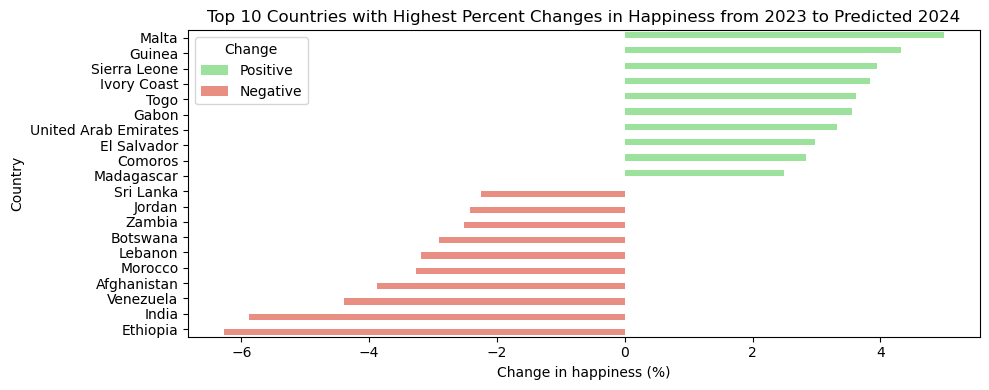

In [58]:
# Split the data into positive/neg
df_2024_positive = df_2024[df_2024['percent_change'] > 0].sort_values('percent_change', ascending=False).head(10)

# Select the top 10 countries with the largest negative changes, then sort in ascending order for visualization
df_2024_negative = df_2024[df_2024['percent_change'] < 0].sort_values('percent_change', ascending=True).head(10)
df_2024_negative = df_2024_negative.sort_values('percent_change', ascending=False)

# Add a new column to distinguish between the positive/negative changes
df_2024_positive['Change'] = 'Positive'
df_2024_negative['Change'] = 'Negative'

df_2024_merged = pd.concat([df_2024_positive, df_2024_negative])

plt.figure(figsize=(10, 4))
sns.barplot(data=df_2024_merged, y='country', x='percent_change', hue='Change', palette=['lightgreen', 'salmon'])
plt.xlabel('Change in happiness (%)')
plt.ylabel('Country')
plt.title('Top 10 Countries with Highest Percent Changes in Happiness from 2023 to Predicted 2024')

plt.tight_layout()
plt.show()


## Limitations

#  **Q3:** Which variables are most strongly associated with happiness?



Looking at the forecast for global happiness in the upcoming year is interesting. For an example, the UAE is expected to witness the largest positive change in their happiness compared to other countries.

What would be even more interesting, is to investigate what are the most salient features that associated with predicting happiness on a global scale. What about the UAE, are the variables that best predict happiness for the UAE population different than remaining countries?

Support Vector Machines are not typically used for feature selection or understanding feature importance because they don't provide direct access to which features are most important. This is because SVMs are more of a "black box" model where interpretability is difficult.



*   Are there any surprising variables that have a significant effect on happiness?

Knowing what variables contribute to citizens' happiness can help governments develop and prioritize policies that enhance those factors. For instance, if variables related to health and education have strong correlations with happiness, then investing more in public health and education policies could lead to a happier population.

Understanding happiness can be important for healthcare providers too. Unhappiness can be both a symptom and a cause of poor health, so healthcare policies might benefit from considering happiness levels in the population.

Traditional economic measures like GDP have long been used as a proxy for societal success, but they don't capture everything that matters to people's lives. A happiness model could provide an additional measure to guide economic decision-making.




## Which variables have the largest influence on determining happiness? **EDIT comments**

We can fit a simple linear regression model to our data and create a plot of residuals (the difference between the observed and predicted values) versus the predicted values. If we see patterns in this plot, it suggests that the relationship between the predictors and the target variable is not entirely linear.

Permutation Importance is a great way to measure the importance of different features in your model. You can use this approach to help interpret your model and understand which features are driving the predictions.

The idea behind Permutation Importance is simple: for each feature, we randomly shuffle the values of that feature and measure how much the model's performance drops. If shuffling a feature's values leads to a big drop in the model's performance, that feature is important; if there's little change, the feature is not important.

You would typically use Permutation Importance on your validation or test data, because it can help you understand which features your model is actually using to make predictions on unseen data. It would be less informative to use Permutation Importance on the training data, because it wouldn't give you insight into how the model performs on new data.

**Permutation Importance**
This technique can help you determine the most influential features in your SVM model by permuting the values of each feature and scoring the impact on model performance. This could be done using sklearn's permutation_importance().

Permutation importance is a useful tool for understanding the impact of a specific feature on the predictions of a machine learning model like SVM. It works by permuting the values of each feature one by one and measuring the decrease in the model's performance. The features that cause the biggest drop in performance are considered the most important.

However, there are a few things to keep in mind when using permutation importance:

Correlated Features: If two features are highly correlated, permuting one of them might not lead to a big drop in performance because the model can still use the other feature to make predictions. In this case, the importance of both features might be underestimated.
Interactions between Features: Permutation importance measures the importance of each feature in isolation and does not take into account interactions between features. If the effect of one feature depends on the value of another feature, this interaction effect won't be captured by permutation importance.
Non-linear and complex relationships: SVMs and other complex models can capture non-linear relationships and interactions between features, which may not be reflected entirely by permutation importance.


[Reference](https://medium.com/@T_Jen/feature-importance-for-any-model-using-permutation-7997b7287aa) used to write this code.

In this case, taking an average of the training sets doesn't make much sense due to the nature of cross-validation. Each set of training data is different because of the shuffling of data, hence it's not advisable to average them.

Instead of averaging the training sets, you should compute the permutation importance on each fold of your cross-validation and then average those importances.

Please note that permutation importance should ideally be calculated on the validation set or unseen data to provide an unbiased estimate of the model performance.

In this code, we calculate the permutation importances for each split in the KFold cross-validation. Then we store these importances in a DataFrame, which allows us to easily calculate the average importance for each feature. Finally, we sort the DataFrame by the average importance to easily see which features are most important. Please note, features with small or zero weights might not be important.

Data leakage can occur when information that would not be available at prediction time is used when building the model. This can lead to overly optimistic performance estimates.

In the provided code, there doesn't seem to be obvious data leakage. You are fitting the model on the training set and then computing permutation importances on the test set, which is the right way to do it.

However, the concept of data leakage with Permutation Importance is a nuanced one. If you calculate Permutation Importance using the test set (as you are doing), it can provide insight into what features were most important for generalizing from the training set to unseen data. But, it could be argued that this is a form of data leakage because you're using the test set to influence your interpretation of the model.

From a strict perspective, the test set should only be used for the final evaluation, and any form of analysis or interpretation of the model (including Permutation Importance) should be done on a separate validation set or using cross-validation on the training set. This prevents any knowledge of the test set from influencing the model or interpretation.

Therefore, while your current approach isn't incorrect, it could be made more robust by calculating Permutation Importance on a separate validation set or using a cross-validation strategy.

 To compute permutation importance on validation sets during cross-validation, we can use the same logic and integrate it into our cross-validation loop.

 This way, we are not using our test set for the calculation of permutation importance but rather using the validation sets from the cross-validation. Note that the `X_test` and `y_test` are essentially acting as validation sets here, as they are different subsets of our training data in each iteration of the cross-validation.



In [52]:
# expect run time to take long (~5-8 minutes)

# Initialize a dataframe to store importances for each fold
importances_df = pd.DataFrame()

# Loop over each split
for i in range(kf.get_n_splits()):

    # Get the data for this fold
    X_train = X_train_list[i]
    X_test = X_test_list[i] # In this case, X_test acts as a validation set
    y_train = y_train_list[i]
    y_test = y_test_list[i] # And y_test acts as validation labels

    # Fit the model
    model.fit(X_train, y_train)

    # Compute the permutation importances
    perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

    # Get feature names
    feature_names = X_encoded.columns.tolist()

    # Get importances and convert them into a dataframe
    importances = pd.DataFrame(perm.feature_importances_, index=feature_names, columns=[f'Importance Fold {i}'])

    # Concatenate the current fold's importances with the previous ones
    importances_df = pd.concat([importances_df, importances], axis=1)

# Compute the average importances
importances_df['Average Importance'] = importances_df.mean(axis=1)

# Sort the importances
importances_df = importances_df.sort_values('Average Importance', ascending=False)

# Print the importances
print(importances_df)

                   Importance Fold 0  Importance Fold 1  Importance Fold 2  \
GDP                         0.507413           0.465044           0.490700   
socialSupport               0.202445           0.161771           0.243737   
corruption                  0.109524           0.116443           0.067898   
freedom                     0.062460           0.067481           0.065562   
country_Singapore           0.102233           0.028318           0.000000   
...                              ...                ...                ...   
country_Cuba                0.000000           0.000000           0.000000   
country_Maldives            0.000000           0.000000           0.000000   
country_Oman                0.000000           0.000000           0.000000   
country_Suriname            0.000000           0.000000           0.000000   
country_Guyana              0.000000           0.000000           0.000000   

                   Importance Fold 3  Importance Fold 4  Import

Including the 'country' as a feature in our model can provide it with additional information about cultural, social, economic, and political differences between countries, which are not captured by the other predictors in our dataset.

However, it's not always straightforward to interpret the effect of the 'country' feature in our model. For instance, 'country_Singapore' having a positive importance means that, all other things being equal, being in Singapore is associated with a higher predicted happiness score compared to the reference country (which, in one-hot encoding, is typically implicitly defined as the country left out of the encoding, or a sort of "average" country effect).

Also, it's important to note that 'country_Singapore' having a non-zero importance doesn't mean that Singapore is more important to global happiness than other countries. Rather, it means that Singapore's happiness score is more different from the reference country's score than other countries are. Other countries may have zero or near-zero importances because their happiness scores are very similar to the reference country's score.

The importance of a feature reflects how much the model's predictions change when you shuffle the values of that feature, thereby destroying the relationship between the feature and the target variable. If the model's predictions change a lot, then the feature is important; if they don't change much, the feature is not important. This method of computing feature importance is robust and can capture complex, nonlinear relationships between features and the target variable.

As such, including the 'country' as a feature might be beneficial for our model if there are country-specific factors that affect happiness and are not captured by our other features. On the other hand, if our other features already capture all of the relevant country-specific factors, then including 'country' as a feature might not improve our model.

In [53]:
importances_df.head()

,Importance Fold 0,Importance Fold 1,Importance Fold 2,Importance Fold 3,Importance Fold 4,Importance Fold 5,Importance Fold 6,Importance Fold 7,Importance Fold 8,Importance Fold 9,Average Importance
GDP,0.507413,0.465044,0.490700,0.508749,0.594404,0.402805,0.465060,0.489867,0.363377,0.581057,0.486848
socialSupport,0.202445,0.161771,0.243737,0.169211,0.198968,0.221252,0.241551,0.186585,0.195657,0.236239,0.205741
corruption,0.109524,0.116443,0.067898,0.101849,0.101810,0.074446,0.070980,0.086256,0.107646,0.101633,0.093848
freedom,0.062460,0.067481,0.065562,0.039408,0.091290,0.069987,0.037213,0.028909,0.065270,0.106628,0.063421
country_Singapore,0.102233,0.028318,0.000000,0.031471,0.151468,0.000000,0.108721,0.035809,0.058394,0.030309,0.054672


In [54]:
print(importances_df.columns)

Index(['Importance Fold 0', 'Importance Fold 1', 'Importance Fold 2',
       'Importance Fold 3', 'Importance Fold 4', 'Importance Fold 5',
       'Importance Fold 6', 'Importance Fold 7', 'Importance Fold 8',
       'Importance Fold 9', 'Average Importance'],
      dtype='object')


In [55]:
importances_df = importances_df[['Average Importance']]
importances_df.head()

,Average Importance
GDP,0.486848
socialSupport,0.205741
corruption,0.093848
freedom,0.063421
country_Singapore,0.054672


We want to create a visualization, but we want the countries to have different color than the other variables i.e., GDP, for clarity.

In [56]:
# The pandas function str.contains can be used to create a boolean mask indicating
# whether each index contains the string 'country'. This mask can then be used to filter the DataFrame.

# Create a boolean mask
mask = importances_df.index.str.contains('country')

# Create DataFrame for features containing 'country'
df_importanceCountry = importances_df[mask]

# Create DataFrame for features not containing 'country'
df_importanceNon_country = importances_df[~mask]

In [57]:
# Remove 'country_' from the index
df_importanceCountry.index = df_importanceCountry.index.str.replace('country_', '', regex=False)
df_importanceCountry.head()

,Average Importance
Singapore,0.054672
Hong Kong S.A.R. of China,0.052752
Ireland,0.049348
Luxembourg,0.046483
Estonia,0.045628


In [58]:
# lets create a color map
def color_negative_red(value):
  """
  Colors values in a DataFrame green if they are positive and red if they are negative.

  Args:
    value (float): The value to color.

  Returns:
    str: The color string.
  """
  if value < 0:
    color = 'red'
  else:
    color = 'green'

  return 'color: %s' % color

In [354]:
# Apply the color map to dataframe for feature imoportance by country
styledCountry = df_importanceCountry[['Average Importance']].style.applymap(color_negative_red)

styledCountry

,Average Importance
Singapore,0.054672
Hong Kong S.A.R. of China,0.052752
Ireland,0.049348
Luxembourg,0.046483
Estonia,0.045628
Japan,0.040881
United Arab Emirates,0.036113
Germany,0.034091
United Kingdom,0.032976
France,0.032374


In [60]:
# Apply the color map to dataframe for feature imoportance by scores
styledScores = df_importanceNon_country[['Average Importance']].style.applymap(color_negative_red)

styledScores

,Average Importance
GDP,0.486848
socialSupport,0.205741
corruption,0.093848
freedom,0.063421
generosity,0.053210
year,0.050054
lifeExpectancy,0.020406


In [357]:
df_importanceNon_country.head()

,Average Importance
GDP,0.486848
socialSupport,0.205741
corruption,0.093848
freedom,0.063421
generosity,0.053210


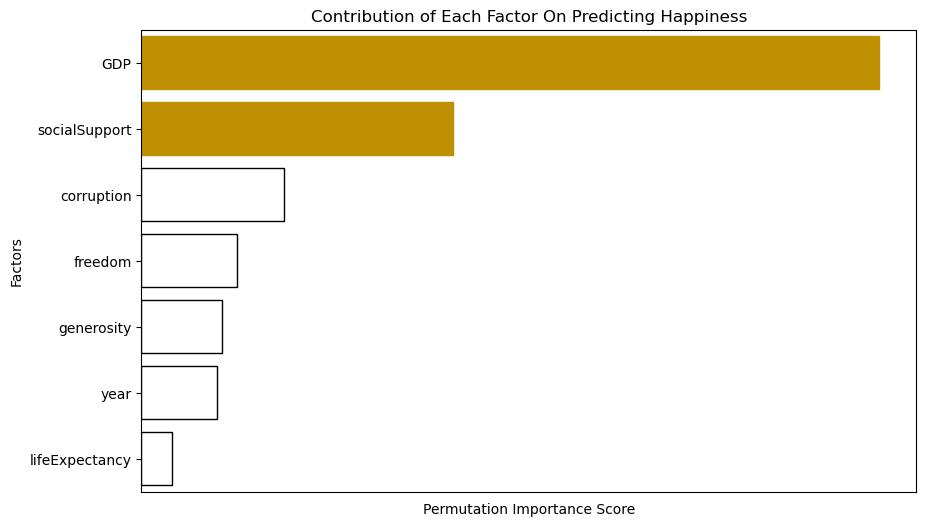

In [375]:
# sort in descending order
df_importanceNon_country_sorted = df_importanceNon_country.sort_values(by='Average Importance', ascending=False)

# create a horizontal bar plot with all bars as white
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=df_importanceNon_country_sorted['Average Importance'], y=df_importanceNon_country_sorted.index, color='white', edgecolor='black')

# Set specific bars to a different color (in this case, the two bars with the highest importance)
bars.patches[0].set_color('#BF9001')
bars.patches[1].set_color('#BF9001')

plt.xlabel("Permutation Importance Score")
plt.ylabel("Factors")
plt.title("Contribution of Each Factor On Predicting Happiness")
plt.xticks([])
plt.show()

## Are there any interacting variables that predict happiness?

Pairplots can be used to visualize potential interactions between features in relation to the target variable. To create this we just need  a 3D plot that can illustrate the relationship between two features and the target variable (happiness).

**which dataset are we using, are we using the same data used to predict the 2024 model?**

In [61]:
# the feature names are from this df
print(X_encoded.columns)

Index(['year', 'GDP', 'socialSupport', 'lifeExpectancy', 'freedom',
       'generosity', 'corruption', 'country_Afghanistan', 'country_Albania',
       'country_Algeria',
       ...
       'country_United Arab Emirates', 'country_United Kingdom',
       'country_United States', 'country_Uruguay', 'country_Uzbekistan',
       'country_Venezuela', 'country_Vietnam', 'country_Yemen',
       'country_Zambia', 'country_Zimbabwe'],
      dtype='object', length=172)


In [62]:
# what are all the possible combinations of features that we can plot?
# the features we are interested in are: GDP, socialSupport, corruption, freedom, generosity, year,and, lifeExpectancy

from itertools import combinations

features = ['GDP', 'socialSupport', 'corruption', 'freedom', 'generosity', 'year', 'lifeExpectancy']

# Get all possible combinations of 2 features
feature_combinations = list(combinations(features, 2))

# let's print them
for combo in feature_combinations:
    print(combo)

('GDP', 'socialSupport')
('GDP', 'corruption')
('GDP', 'freedom')
('GDP', 'generosity')
('GDP', 'year')
('GDP', 'lifeExpectancy')
('socialSupport', 'corruption')
('socialSupport', 'freedom')
('socialSupport', 'generosity')
('socialSupport', 'year')
('socialSupport', 'lifeExpectancy')
('corruption', 'freedom')
('corruption', 'generosity')
('corruption', 'year')
('corruption', 'lifeExpectancy')
('freedom', 'generosity')
('freedom', 'year')
('freedom', 'lifeExpectancy')
('generosity', 'year')
('generosity', 'lifeExpectancy')
('year', 'lifeExpectancy')


In [63]:
# above we found all the possible combinations. So how many combination in total can we plot?
print(len(feature_combinations))

21


We have 21 possible plots to make. We could manually make a plot for each pair, but lets make our life easier and just use a loop to do it all at once.

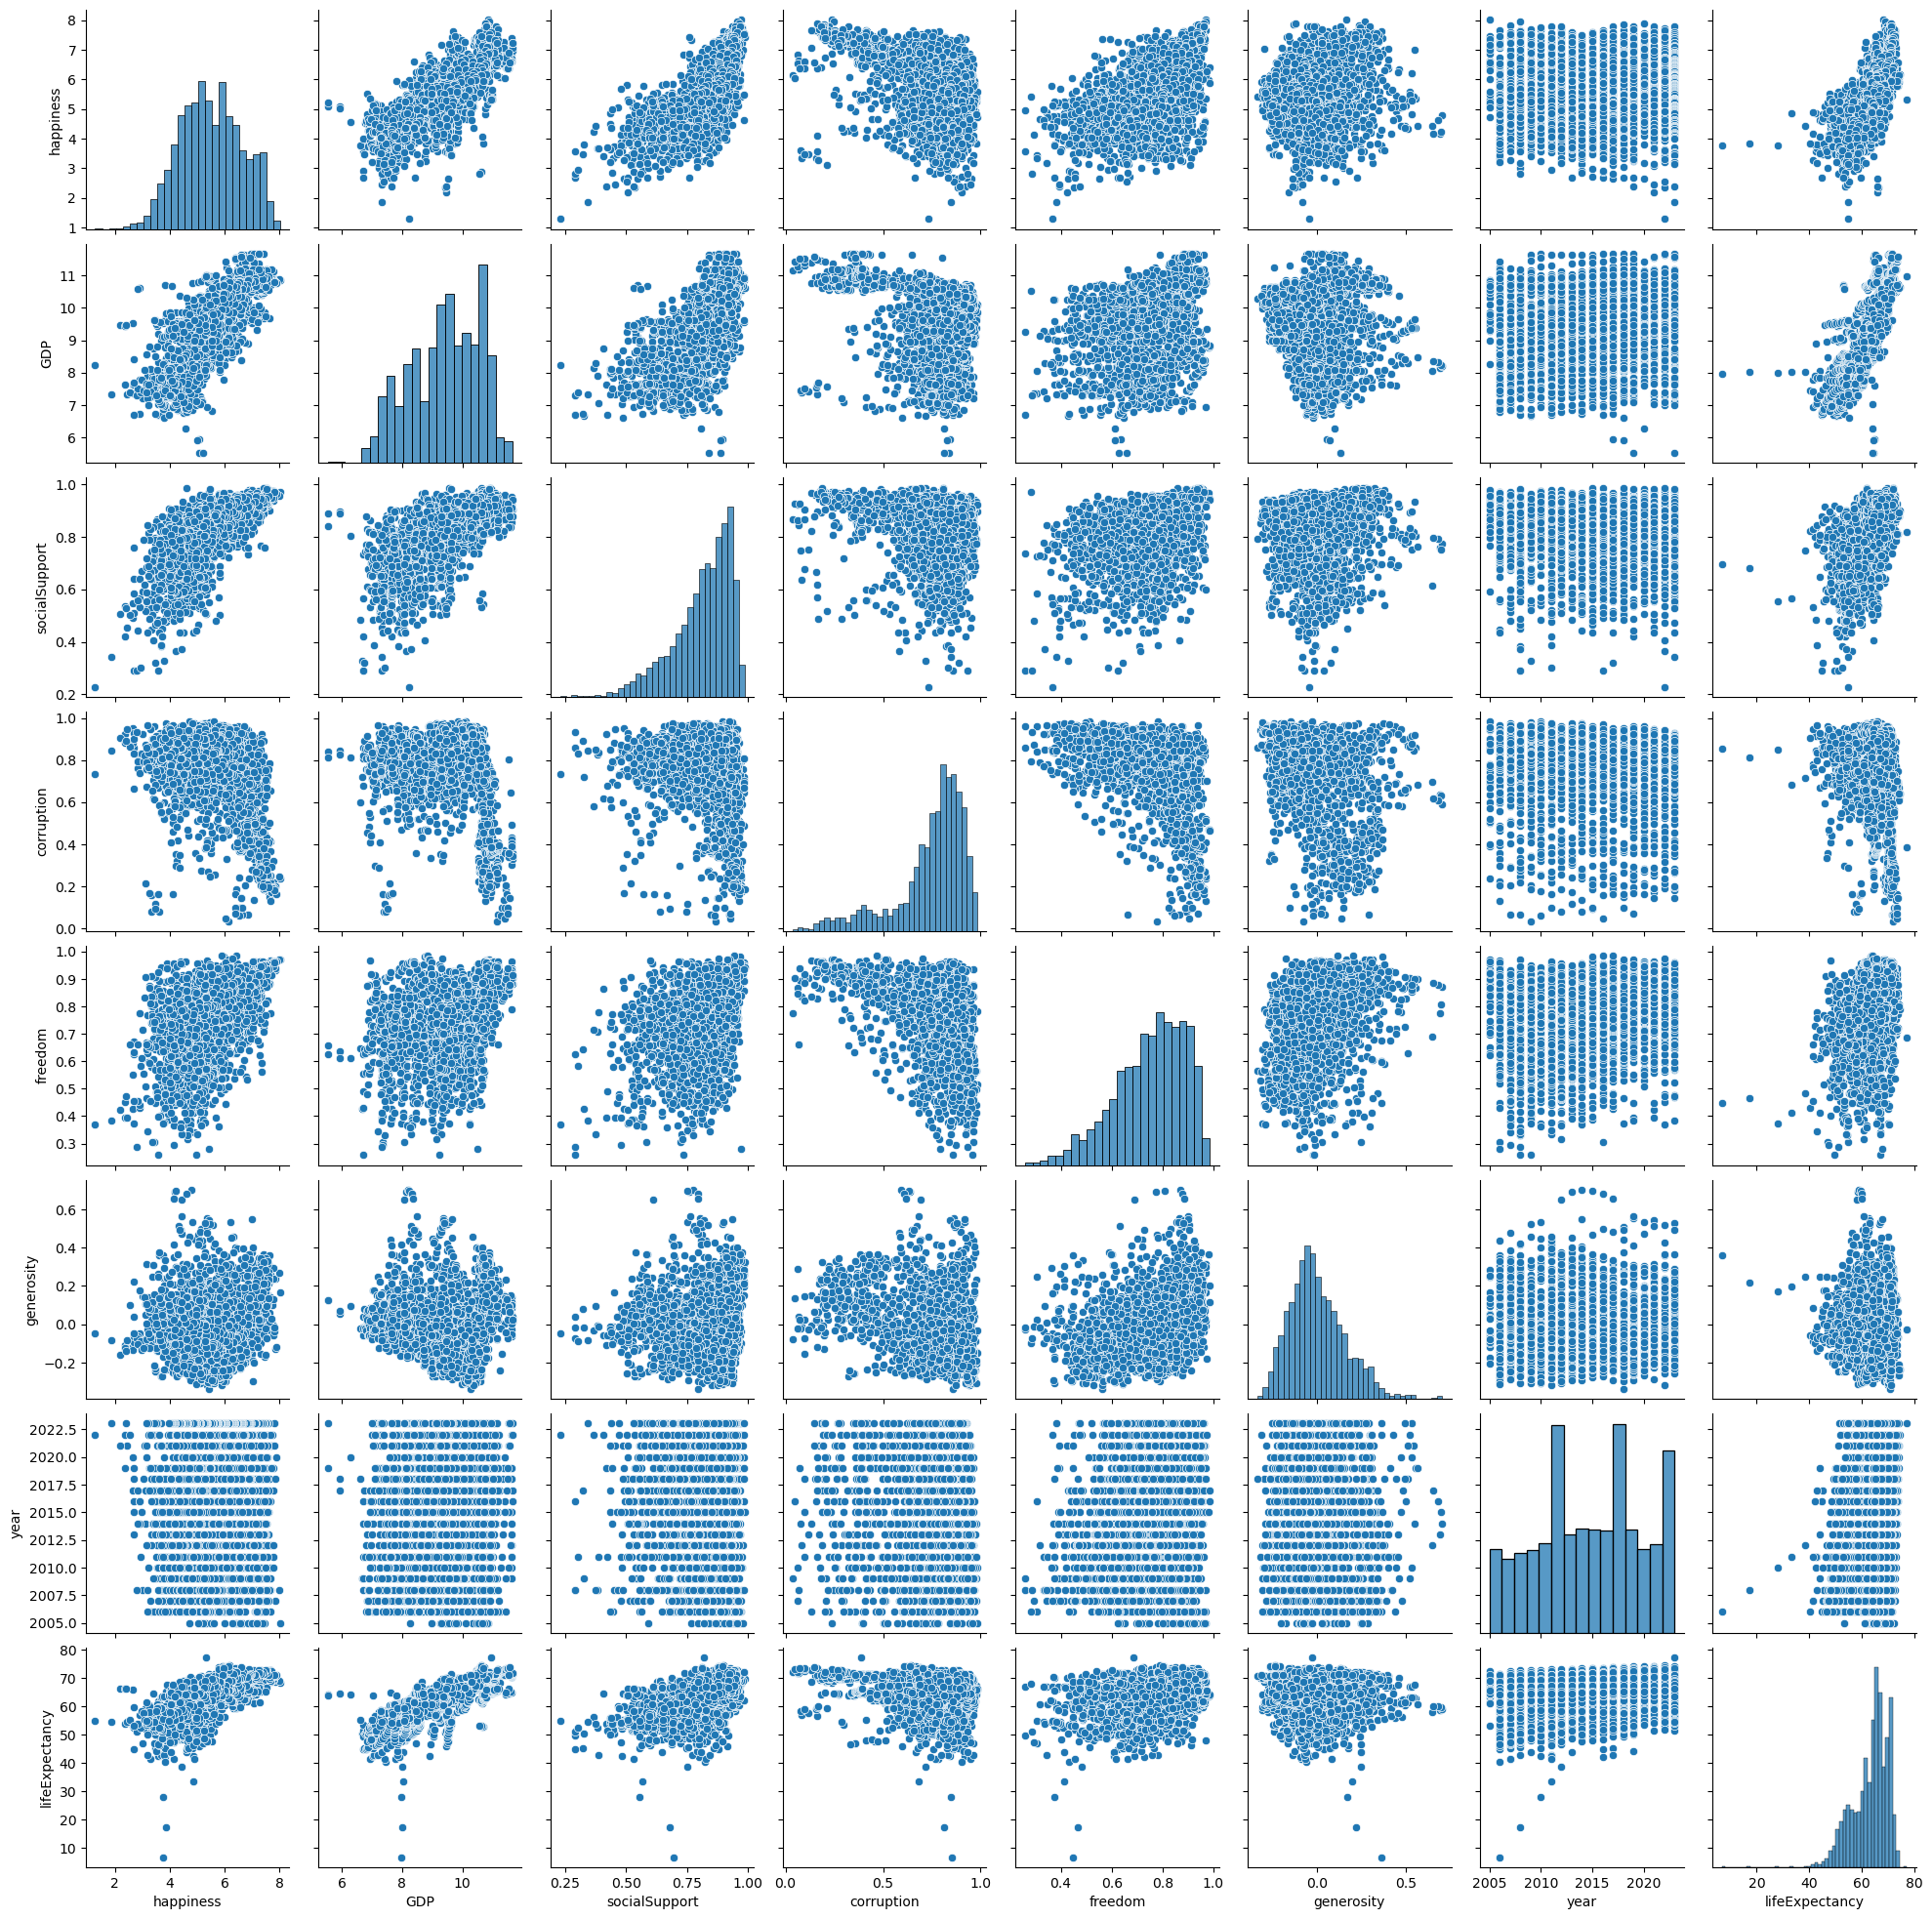

In [88]:
df_subset.reset_index(drop=True, inplace=True)
sns.pairplot(df_subset)
plt.show()

The pairplots above allows us to visually see which two features are dependent on each other. Let's compute the R-squared to numerically determine which two pairs are goof predictors of each other.

An R-squared value ranges from 0 to 1. A high R-squared value, closer to 1, indicates that a large proportion of the variability in the dependent variable is accounted for by the independent variable(s).

In the context of the relationship between two variables, a high R-squared value would mean that there's a strong linear relationship between the two variables. More specifically, it means that the independent variable is a good predictor of the dependent variable, as it accounts for a large proportion of the observed variation in the dependent variable. In other words, how well does the change in the independent variable predict the change in the dependent variable.

Simimlar to [Kaur et al., 2019](https://www.mdpi.com/2076-3417/9/8/1613), we will use RSME to evaluate performance. The lower values of RMSE indicated better fit models. 

In [118]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() # Initialize the model

df_no_country_happiness = df.drop(columns=['country', 'happiness']) # Remove country and happiness columns

metrics_df = pd.DataFrame(columns=['r','R-squared', 'RMSE']) # Prepare dataframe to store R-squared and RMSE values

# Loop over each pair of columns
for i, col1 in enumerate(df_no_country_happiness.columns):
    for j, col2 in enumerate(df_no_country_happiness.columns):
        # Skip when columns are the same
        if i < j:
            # Fit the model
            model.fit(df_no_country_happiness[[col1]], df_no_country_happiness[col2])
            # Get r
            r = scipy.stats.pearsonr(df_no_country_happiness[col1], df_no_country_happiness[col2])[0]
            # Get R-squared
            r_squared = model.score(df_no_country_happiness[[col1]], df_no_country_happiness[col2])
            # Predict values
            predictions = model.predict(df_no_country_happiness[[col1]])
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(df_no_country_happiness[col2], predictions))
            # Store R-squared and RMSE
            metrics_df.loc[f'{col1} vs {col2}'] = [r, r_squared, rmse]

# Sort the dataframe such that the models with the highest correlation are at the top
metrics_df['abs_r'] = metrics_df['r'].abs() # we'll sort by absolute value so that strong negative relationships are also near the top of the dataframe
metrics_df = metrics_df.sort_values('abs_r', ascending=False)

print(metrics_df)


                                        r  R-squared      RMSE     abs_r
GDP vs lifeExpectancy            0.805471   0.648784  4.035998  0.805471
GDP vs socialSupport             0.672463   0.452206  0.089716  0.672463
socialSupport vs lifeExpectancy  0.596624   0.355960  5.465379  0.596624
freedom vs corruption           -0.468796   0.219770  0.162530  0.468796
socialSupport vs freedom         0.410315   0.168358  0.126642  0.410315
lifeExpectancy vs freedom        0.372909   0.139061  0.128853  0.372909
GDP vs corruption               -0.364998   0.133224  0.171307  0.364998
GDP vs freedom                   0.361559   0.130725  0.129475  0.361559
freedom vs generosity            0.314469   0.098891  0.150664  0.314469
lifeExpectancy vs corruption    -0.288514   0.083240  0.176177  0.288514
generosity vs corruption        -0.270057   0.072931  0.177165  0.270057
year vs freedom                  0.235856   0.055628  0.134952  0.235856
socialSupport vs corruption     -0.225346   0.05078

`GDP vs lifeExpectancy` , `GDP vs socialSupport`, and  `socialSupport vs lifeExpectancy` have a correlation that is either at a moderate or above moderate strength. These will be our candidates.

According to the r-squared;
* `GDP` explains `64.9%` of the vairance in `lifeExpectancy`.
* `GDP` explains `45.2%` of the vairance in `socialSupport`.
* `socialSupport` explains `35.6%` of the vairance in `lifeExpectancy`.

These three relationships appear to be dependent on each other. 

It turns out `GDP` is predictive of both `lifeExpectancy` and `socialSupport`. Let's model that!

Static plots 3d are hard to visually inspect, so we will also make an interactive one too.

In [220]:
!pip install plotly #    Default renderer: 'plotly_mimetype+notebook_connected'
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='chrome' # 3d plots will be opened in browser since can't figure out how to render in notebook

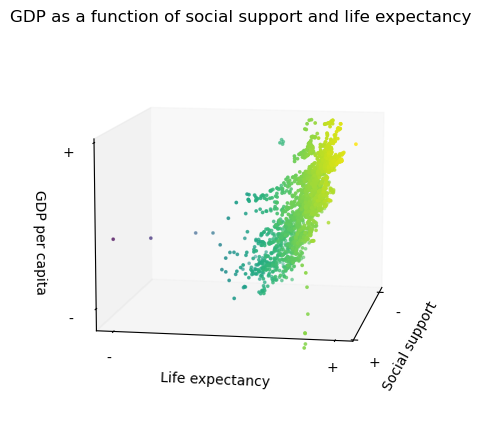

In [349]:
scaler_life_social = StandardScaler() # Create a new scaler for the features
X_life_social  = scaler_life_social.fit_transform(X_encoded[['socialSupport', 'lifeExpectancy']]) # Fit and transform the features


x = X_life_social[:, 0]  # social support
y = X_life_social[:, 1]  # life expectancy
z = X_encoded[['GDP']].values.ravel()  # GDP per capita. our z value needs to be a 1d array, not column from df
# Create an interactive3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=3, color=z, colorscale='Viridis'))])

fig.update_layout(scene=dict(xaxis=dict(title='Social support'),
                             yaxis=dict(title='Life expectancy'),
                             zaxis=dict(title='GDP per capita')),
                  title='GDP as a function of social support and life expectancy')

fig.update_layout(scene=dict(
    xaxis=dict(title='Social support', tickvals=[-4, 1], ticktext=['-', '+'], showticklabels=True),
    yaxis=dict(title='Life expectancy', tickvals=[-8, 2], ticktext=['-', '+'], showticklabels=True),
    zaxis=dict(title='GDP per capita', tickvals=[6, 11], ticktext=['-', '+'], showticklabels=True)),
    title='GDP as a function of social support and life expectancy'
)


fig.show()

# Create a static 3D scatter plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=y, marker='o', s=3) # setting color = y elucidates dimensionality despite graph being 2d


ax.set_xlabel('Social support')
ax.set_ylabel('Life expectancy')
ax.set_zlabel('GDP per capita')
ax.set_title('GDP as a function of social support and life expectancy')

# remove the tick labels since they are not meaningful in and of themselves, just add +/- for reference

ax.set_xlim([-5, 1])  # set the range 
ax.set_ylim([-8, 2])  # set the range 
ax.set_zlim([6, 11])  # set the range 

ax.set_xticks([-4.5,1])  
ax.set_yticks([-7.5,1.5])
ax.set_zticks([6.5,11])

ax.set_xticklabels(['-','+'])  
ax.set_yticklabels(['-','+'])
ax.set_zticklabels(['-','+'])


ax.view_init(elev=10, azim=10) # let's rotate graph along z-axis to get a better look at the data distribution 

# alpha = 0.1, 0.1, 0.1, 0.1 # RGBA
alpha = 0, 0, 0, 0 # RGBA


ax.xaxis._axinfo["grid"]['color'] =  (alpha)
ax.yaxis._axinfo["grid"]['color'] =  (alpha)
ax.zaxis._axinfo["grid"]['color'] =  (alpha)

plt.show()

Importance permutation performed earlier revealed the ranking of which independent variable has the greatest influence on our tagret variable, happiness in the SVM regression. 

Now that we have 3 candidates from our linear regression, lets see if any of the pairs of independent variables are good predictors of happiness. 

Where importance permutation was a univariate analysis, now we will perform a type of multivariate analysis to see if perhaps happiness is perdicted by a combination of independent variables, rather than just one.

To conduct this analysis, we will add a third dimension (z-axis) that will represent happiness, with the pairs `GDP vs lifeExpectancy` , `GDP vs socialSupport`, and  `socialSupport vs lifeExpectancy` plotted on the x- and y-axis.

For plots where we observe that there is a strong linear relationship between two variables, let's check to see if the combination of those to also are predictors of happines.

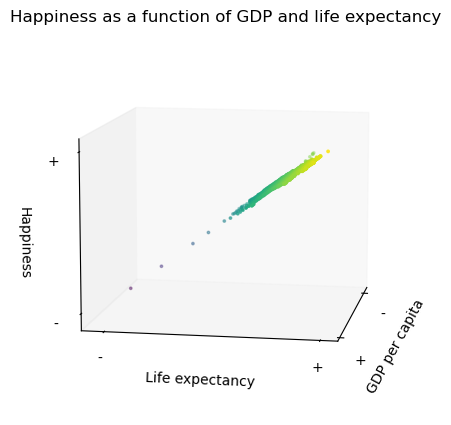

In [347]:
scaler_GDP_life = StandardScaler() # Create a new scaler for the features
X_GDP_life = scaler_GDP_life.fit_transform(X_encoded[['GDP', 'lifeExpectancy']]) # Fit and transform the features


x = X_GDP_life[:, 0]  # GDP per capita
y = X_GDP_life[:, 1]  # life expectancy
z = y  # Happiness scores

# Create an interactive3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=3, color=z, colorscale='Viridis'))])

fig.update_layout(scene=dict(xaxis=dict(title='GDP per capita',tickvals=[6, 11], ticktext=['-', '+'], showticklabels=True),
                             yaxis=dict(title='Life expectancy', tickvals=[-8, 2], ticktext=['-', '+'], showticklabels=True),
                             zaxis=dict(title='Happiness', tickvals=[-8, 2], ticktext=['-', '+'], showticklabels=True)),
                  title='Happiness as a function of GDP and life expectancy')

fig.show()


# Create a static 3D scatter plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=z, marker='o',s=3) # setting color = z elucidates dimensionality despite graph being 2d


ax.set_xlabel('GDP per capita')
ax.set_ylabel('Life expectancy')
ax.set_zlabel('Happiness')
ax.set_title('Happiness as a function of GDP and life expectancy')

# remove the tick labels since they are not meaningful in and of themselves, just add +/- reference
ax.set_xticks([-3, 2])  
ax.set_yticks([-8,2])
ax.set_zticks([-8, 2])

ax.set_xticklabels(['-','+'])  
ax.set_yticklabels(['-','+'])
ax.set_zticklabels(['-','+'])


ax.view_init(elev=10, azim=10) # let's rotate graph along z-axis to get a better look at the data distribution 

# alpha = 0.1, 0.1, 0.1, 0.1 # RGBA
alpha = 0, 0, 0, 0 # RGBA

ax.xaxis._axinfo["grid"]['color'] =  (alpha)
ax.yaxis._axinfo["grid"]['color'] =  (alpha)
ax.zaxis._axinfo["grid"]['color'] =  (alpha)

plt.show()

There is a 2D plane that forms in this 3D space indicating the correlation between the life expectancy, GDP, and happiness, suggesting that they are not independent but interrelated. 

The 45-degree line between happines and life expectancy represents the direction of greatest change in happiness with respect to GDP and life expectancy - in other words, for each unit increase in GDP and life expectancy, happiness changes along that direction. 

From the fact that a plane forms in the 3D graph, we can infer that there's a relationship where happiness can be predicted as a function of GDP and life expectancy. The exact nature of this function and the contributions of each variable would need to be investigated through regression analysis.

The linear regression we conducted earlier between GDP and life expectancy suggests there's a strong positive correlation between these variables. However, this doesn't tell us anything about the impact these variables have on happiness. For that, we would need to perform multiple linear regression with happiness as the dependent variable, and GDP and life expectancy as independent variables. This allows us to understand the contribution of each variable to happiness while keeping the other constant. 

For example, we might find that for every unit increase in GDP, happiness increases by 'a' units, holding life expectancy constant. Similarly, for every unit increase in life expectancy, happiness increases by 'b' units, holding GDP constant. 

This would give us a much more precise understanding of how each variable independently contributes to happiness, while also considering their joint effect. 

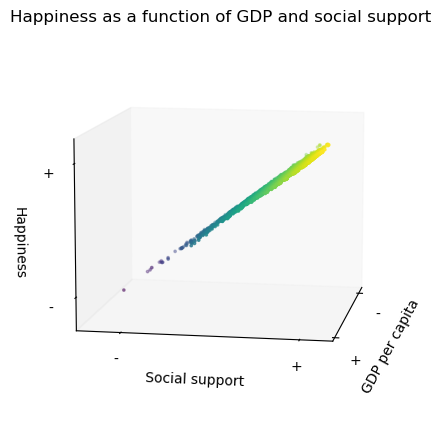

In [345]:
scaler_GDP_Social = StandardScaler()# Create a new scaler for the features
X_GDP_Social = scaler_GDP_Social.fit_transform(X_encoded[['GDP', 'socialSupport']]) # Fit and transform the features

x = X_GDP_Social[:, 0]  
y = X_GDP_Social[:, 1]  
z = y  # Happiness scores

# Create an interactive 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=3, color=z, colorscale='Viridis'))])

fig.update_layout(scene=dict(xaxis=dict(title='GDP per capita', tickvals=[-3, 2], ticktext=['-', '+'], showticklabels=True),
                             yaxis=dict(title='Social support', tickvals=[-4, 1], ticktext=['-', '+'], showticklabels=True),
                             zaxis=dict(title='Happiness', tickvals=[-4, 1], ticktext=['-', '+'], showticklabels=True)),
                  title='Happiness as a function of GDP and social support')

fig.show()

# Create a static 3D scatter plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=z, marker='o', s=3) # setting color = z elucidates dimensionality despite graph being 2d

ax.set_xlabel('GDP per capita')
ax.set_ylabel('Social support')
ax.set_zlabel('Happiness')
ax.set_title('Happiness as a function of GDP and social support')

# remove the tick labels since they are not meaningful in and of themselves, just add +/- for reference
ax.set_xticks([-3, 2])  
ax.set_yticks([-4, 1])
ax.set_zticks([-4, 1])

ax.set_xticklabels(['-','+'])  
ax.set_yticklabels(['-','+'])
ax.set_zticklabels(['-','+'])


ax.view_init(elev=10, azim=10) # let's rotate graph along z-axis to get a better look at the data distribution 

# alpha = 0.1, 0.1, 0.1, 0.1 # RGBA
alpha = 0, 0, 0, 0 # RGBA

ax.xaxis._axinfo["grid"]['color'] =  (alpha)
ax.yaxis._axinfo["grid"]['color'] =  (alpha)
ax.zaxis._axinfo["grid"]['color'] =  (alpha)

plt.show()

After inspecting the interactive plot, the we see a perfect linear relationship between happiness and social support, projecting a plane in the third dimension which represents GDP. The formation of this plane in 3d space means that there is indeed a strong correlation between social support and happiness.

Earlier we found a strong positive correlation between GDP and social support when we performed a linear regression between these two variables. This suggests that countries with higher GDP tend to have higher levels of social support.

When we introduced happiness into the mix and visualized these three variables in a 3D plot, we observed that they form a plane angled at 45˚ between happiness and social support. The line at a 45-degree angle you're describing likely represents the direction of greatest change - so as you move along this line, you're increasing both social support and happiness, which confirms your initial finding that these two variables are positively correlated.

The fact that these three variables form a plane in our 3D plot suggests that they're not independent - if they were, we would expect them to fill up the 3D space rather than lying on a flat plane. This could indicate that there's a linear relationship between these three variables, i.e., they're not just related pairwise, but also collectively.

However, the formation of the plane doesn't tell you which variable(s) predict happiness. The plane only shows that there's some relationship between the three variables. To figure out which variable(s) predict happiness, we would need to run a multiple regression with happiness as the dependent variable and both GDP and social support as independent variables.

If our regression analysis finds that both GDP and social support have significant coefficients, this would suggest that both variables contribute to predicting happiness, even when we control for the other variable. If only social support has a significant coefficient, this would suggest that once we control for social support, GDP doesn't add any additional predictive power. And vice versa if only GDP is significant.

It's also possible that GDP has a more complex relationship with happiness that isn't apparent in a linear model. Perhaps GDP might only affect happiness up to a certain point, after which more GDP doesn't result in more satisfaction in life.


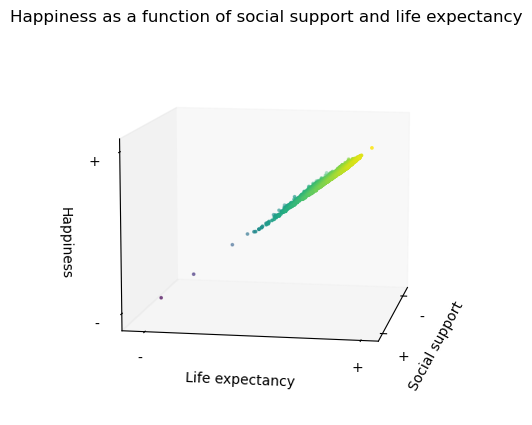

In [344]:
scaler_social_life = StandardScaler() # Create a new scaler for the features
X_social_life = scaler_social_life.fit_transform(X_encoded[['socialSupport', 'lifeExpectancy']]) # Fit and transform the features

x = X_social_life[:, 0]  
y = X_social_life[:, 1]  
z = y  # Happiness scores

# Create an interactive 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(size=3, color=z, colorscale='Viridis'))])

fig.update_layout(scene=dict(xaxis=dict(title='Social support', tickvals=[-4, 1], ticktext=['-', '+'], showticklabels=True),
                             yaxis=dict(title='Life expectancy', tickvals=[-8, 2], ticktext=['-', '+'], showticklabels=True),
                             zaxis=dict(title='Happiness', tickvals=[-8, 2], ticktext=['-', '+'], showticklabels=True)),
                  title='Happiness as a function of social support and life expectancy')

fig.show()

# Create a static 3d plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=z, marker='o', s=3) # setting color = z elucidates dimensionality despite graph being 2d

ax.set_xlabel('Social support')
ax.set_ylabel('Life expectancy')
ax.set_zlabel('Happiness')
ax.set_title('Happiness as a function of social support and life expectancy')

# remove the tick labels since they are not meaningful in and of themselves, just add +/- for reference
ax.set_xticks([-4, 1])  
ax.set_yticks([-8, 2])
ax.set_zticks([-8, 2])

ax.set_xticklabels(['-','+'])  
ax.set_yticklabels(['-','+'])
ax.set_zticklabels(['-','+'])


ax.view_init(elev=10, azim=10) # let's rotate graph along z-axis to get a better look at the data distribution 

# alpha = 0.1, 0.1, 0.1, 0.1 # RGBA
alpha = 0, 0, 0, 0 # RGBA

ax.xaxis._axinfo["grid"]['color'] =  (alpha)
ax.yaxis._axinfo["grid"]['color'] =  (alpha)
ax.zaxis._axinfo["grid"]['color'] =  (alpha)

plt.show()

There is a formation of a 2D plane in this 3D space, indicating that these three variables are likely interconnected rather than existing independently. The presence of a plane suggests that there might exist a linear combination of social support and life expectancy that can predict happiness.

The 45-degree line we see is the plane's normal vector, showing the direction of the greatest change in the plane, implying that both life expectancy and social support are changing proportionally with happiness.

Earlier, our linear regression analysis between social support and life expectancy has shown a strong positive correlation. This implies that a significant proportion of the variation in life expectancy can be explained by social support. But it doesn't necessarily mean that these two are the only predictors of happiness.

When it comes to interpreting the 3D graph, we need to consider all three variables together. If social support and life expectancy form a plane with happiness, it suggests a linear relationship between these variables, meaning all of them collectively contribute to the model. 

To better understand how each variable (social support and life expectancy) independently and jointly affect happiness, we would need to run a multiple linear regression with happiness as the dependent variable and social support and life expectancy as independent variables. This would allow us to examine the impact of each variable on happiness while controlling for the other. The resulting coefficients would help us understand the predictive contribution of each variable.

though we we able to visually see if two variables predicted happiness, for future directions we can construct a linear fixed effects model to get the weight each variable has towards predicting happines. This method will also inform us if there are more than just 2 interacting variables.

# Focusing on the Governance-Quality Measures based on Data from the Worldwide Governance Indicators (WGI) Project

# Pending

## Scatter diagram of the distribution between each parameter

## Correlation matrix between all the features

why? Correlation is used to identify the pairwise correlation of all columns that exist in the dataset. By using heatmap, it explicitly exhibits the attributes which are strongly correlated to each other.

## Which country is performing the best?

Happiness can be a useful metric for international comparisons. Countries often strive to learn from each other's successes and failures, and understanding the factors that contribute to happiness can provide valuable insights.

### Overall happiness

### High performers in each independent variable

### Heatmap of Global happiness

Geographical Visualization of Happiness Score: to help to comprehend trends in our data, identify outliers as well as other areas of interest

# Limitations

While our model could be very valuable, it's important to remember that these are complex issues, and that the model's predictions should ideally be one part of a larger decision-making process. It's also crucial to consider factors such as data quality and representation, the potential for overfitting, and ethical considerations.

**What are the reason a machine learning model can perform really well, but the dimension in the data doesnt capture complex behaviour.**

# Conclusions

As a consequence, SVM regression might be used to determine the happiness of a country. If happiness can be predicted at an early stage, it is beneficial to stakeholds to prevent a decline.

Maximize life satisfaction.